Program:  K-Means Clustering
Analyst:  Alyssa Fedgo
Date:     June 22, 2021
Purpose:  Group players by their performance

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Read in data set and keep only features needed

In [10]:
df=pd.read_csv("ASA All PGA Raw Data - Tourn Level.csv.txt",parse_dates=['date'])
features=df[['Score','player','sg_total','date']]
features.head()

,Score,player,sg_total,date
0,-8,Aaron Baddeley,1.53,2015-02-01
1,-7,Aaron Baddeley,-0.37,2015-02-15
2,3,Aaron Baddeley,-2.34,2015-02-08
3,NaN,Aaron Baddeley,NaN,2015-02-22
4,11,Aaron Baddeley,-5.23,2015-05-10


In [14]:
features.dtypes

Score               object
player              object
sg_total           float64
date        datetime64[ns]
dtype: object

Convert score to numeric

In [18]:
features=features.replace('E','0')
features['Score']=features['Score'].astype(float)
features.dtypes

Score              float64
player              object
sg_total           float64
date        datetime64[ns]
dtype: object

In [90]:
len(features['player'])

31822

Average score and strokes gained total by player

In [22]:
df_avg=features.groupby('player',as_index=False)[['Score','sg_total']].mean().dropna()
df_avg.set_index('player',inplace=True)
df_avg.head()


,Score,sg_total
player,,
Aaron Baddeley,-1.486239,-0.290000
Aaron Rai,12.000000,-2.850000
Aaron Wise,-2.910256,0.105897
Abraham Ancer,-3.204545,0.364318
Adam Hadwin,-1.952756,0.197244


In [91]:
len(df_avg.index)

434

Standardize features for comparison

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_avg)
scaled_features_df = pd.DataFrame(scaled_features, index=df_avg.index, columns=df_avg.columns)
scaled_features_df.head()

,Score,sg_total
player,,
Aaron Baddeley,-0.487402,0.387280
Aaron Rai,2.384536,-1.317737
Aaron Wise,-0.790651,0.650956
Abraham Ancer,-0.853321,0.823070
Adam Hadwin,-0.586748,0.711795


K-means clustering

In [29]:
kmeans = KMeans(
            init="random",
            n_clusters=3,
            n_init=10,
            max_iter=300,
            random_state=42
    )

kmeans.fit(scaled_features_df)

KMeans(init='random', n_clusters=3, random_state=42)

In [30]:
kmeans.inertia_

221.7648224276977

In [31]:
kmeans.cluster_centers_

array([[ 2.61347612, -2.65372403],
       [ 0.46252934, -0.36129974],
       [-0.50520891,  0.46819324]])

In [32]:
kmeans.n_iter_

10

In [33]:
kmeans.labels_[:5]

array([2, 0, 2, 2, 2])

Elbow Method

In [34]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features_df)
    sse.append(kmeans.inertia_)

C:\Users\afedgo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


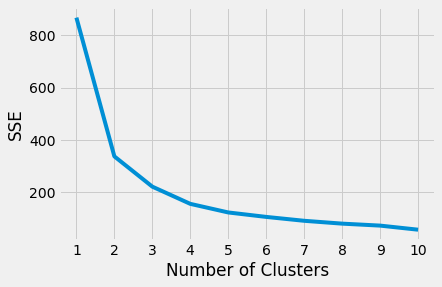

In [35]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
Programmaticaly find the elbow

In [36]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow



3

Evaluating clusters with silhouette coefficient instead of elbo

In [37]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features_df)
    score = silhouette_score(scaled_features_df, kmeans.labels_)
    silhouette_coefficients.append(score)


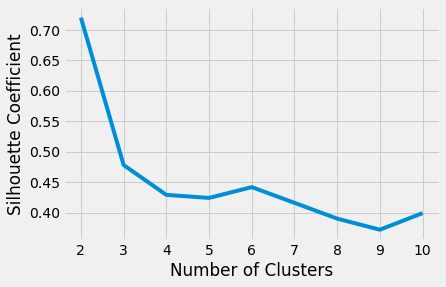

In [38]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


Pipeline

In [83]:
clusterer = Pipeline(
    [
        (
            "kmeans",
             KMeans(
                n_clusters=6,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
 )

clusterer.fit(scaled_features_df)

Pipeline(steps=[('kmeans',
                 KMeans(max_iter=500, n_clusters=6, n_init=50,
                        random_state=42))])

C:\Users\afedgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


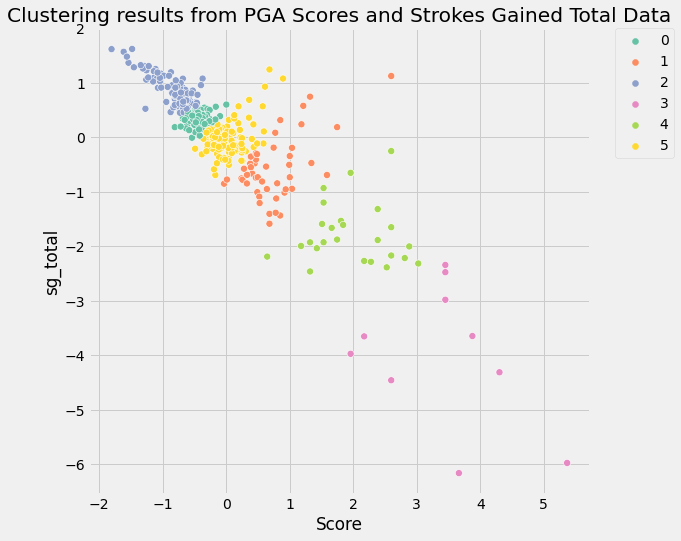

In [84]:
scaled_features_df["predicted_cluster"] = clusterer["kmeans"].labels_
    
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
     "Score",
     "sg_total",
     s=50,
     data=scaled_features_df,
     hue="predicted_cluster",
     palette="Set2",
 )

scat.set_title(
     "Clustering results from PGA Scores and Strokes Gained Total Data"
 )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [85]:
scaled_features_df.head()

,Score,sg_total,predicted_cluster
player,,,
Aaron Baddeley,-0.487402,0.387280,0
Aaron Rai,2.384536,-1.317737,4
Aaron Wise,-0.790651,0.650956,2
Abraham Ancer,-0.853321,0.823070,2
Adam Hadwin,-0.586748,0.711795,2


In [86]:
scaled_features_df.loc[scaled_features_df['predicted_cluster']==2].to_csv('TopPlayers.csv')


Select top 20 for score and sg_total

In [88]:
scaled_features_df.nsmallest(20,'Score')

,Score,sg_total,predicted_cluster
player,,,
Jon Rahm,-1.804443,1.620264,2
Dustin Johnson,-1.614001,1.571595,2
Patrick Cantlay,-1.562814,1.482548,2
Collin Morikawa,-1.537765,1.369895,2
Rory McIlroy,-1.480565,1.623500,2
Webb Simpson,-1.452717,1.286666,2
Justin Thomas,-1.344923,1.325908,2
Jordan Spieth,-1.309909,1.264474,2
Jason Day,-1.284471,1.308610,2


In [89]:
scaled_features_df.nlargest(20,'sg_total')

,Score,sg_total,predicted_cluster
player,,,
Rory McIlroy,-1.480565,1.623500,2
Jon Rahm,-1.804443,1.620264,2
Dustin Johnson,-1.614001,1.571595,2
Patrick Cantlay,-1.562814,1.482548,2
Collin Morikawa,-1.537765,1.369895,2
Justin Thomas,-1.344923,1.325908,2
Viktor Hovland,-1.219288,1.309123,2
Jason Day,-1.284471,1.308610,2
Webb Simpson,-1.452717,1.286666,2
